<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="45%" align="right" border="4">

# Quickstart

This brief first part illustrates---without much explanation---the usage of the DX Analytics library. It models two risk factors, two derivatives instruments and values these in a portfolio context.

In [1]:
import dx
import datetime as dt
import pandas as pd
from pylab import plt
plt.style.use('seaborn')

## Risk Factor Models

The first step is to define a **model for the risk-neutral discounting**.

In [2]:
r = dx.constant_short_rate('r', 0.01)

We then define a **market environment** containing the major parameter specifications needed,

In [3]:
me_1 = dx.market_environment('me', dt.datetime(2016, 1, 1))

In [4]:
me_1.add_constant('initial_value', 100.)
  # starting value of simulated processes
me_1.add_constant('volatility', 0.2)
  # volatiltiy factor
me_1.add_constant('final_date', dt.datetime(2017, 6, 30))
  # horizon for simulation
me_1.add_constant('currency', 'EUR')
  # currency of instrument
me_1.add_constant('frequency', 'W')
  # frequency for discretization
me_1.add_constant('paths', 10000)
  # number of paths
me_1.add_curve('discount_curve', r)
  # number of paths

Next, the model object for the **first risk factor**, based on the geometric Brownian motion (Black-Scholes-Merton (1973) model).

In [5]:
gbm_1 = dx.geometric_brownian_motion('gbm_1', me_1)

Some paths visualized.

In [6]:
pdf = pd.DataFrame(gbm_1.get_instrument_values(), index=gbm_1.time_grid)

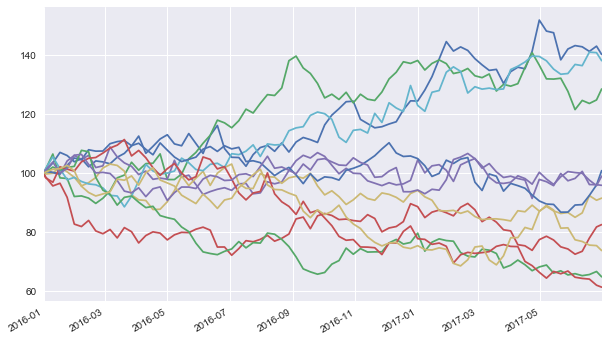

In [7]:
%matplotlib inline
pdf.ix[:, :10].plot(legend=False, figsize=(10, 6))

**Second risk factor** with higher volatility. We overwrite the respective value in the market environment.

In [8]:
me_2 = dx.market_environment('me_2', me_1.pricing_date)
me_2.add_environment(me_1)  # add complete environment
me_2.add_constant('volatility', 0.5)  # overwrite value

In [9]:
gbm_2 = dx.geometric_brownian_motion('gbm_2', me_2)

In [10]:
pdf = pd.DataFrame(gbm_2.get_instrument_values(), index=gbm_2.time_grid)

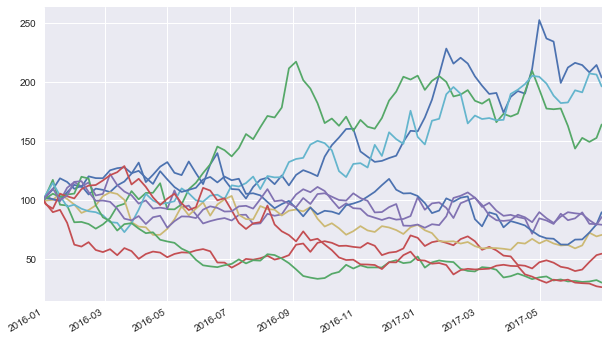

In [11]:
pdf.iloc[:, :10].plot(legend=False, figsize=(10, 6))

## Valuation Models

Based on the risk factors, we can then define derivatives models for valuation. To this end, we need to add at least one (the `maturity`), in general two (`maturity` and `strike`), parameters to the market environments.

In [12]:
me_opt = dx.market_environment('me_opt', me_1.pricing_date)
me_opt.add_environment(me_1)
me_opt.add_constant('maturity', dt.datetime(2017, 6, 30))
me_opt.add_constant('strike', 110.)

The first derivative is an **American put option** on the first risk factor `gbm_1`.

In [13]:
am_put = dx.valuation_mcs_american_single(
            name='am_put',
            underlying=gbm_1,
            mar_env=me_opt,
            payoff_func='np.maximum(strike - instrument_values, 0)')

Let us calculate a **Monte Carlo present value estimate** and estimates for the option **Greeks**.

In [14]:
am_put.present_value()

15.013

In [15]:
am_put.delta()

-0.5411

In [16]:
am_put.gamma()

-0.0082

In [17]:
am_put.vega()

51.1584

In [18]:
am_put.theta()

-3.7421

In [19]:
am_put.rho()

-71.1355

The second derivative is a **European call option** on the second risk factor `gbm_2`.

In [20]:
eur_call = dx.valuation_mcs_european_single(
            name='eur_call',
            underlying=gbm_2,
            mar_env=me_opt,
            payoff_func='np.maximum(maturity_value - strike, 0)')

Valuation and Greek estimation for this option.

In [21]:
eur_call.present_value()

20.641978

In [22]:
eur_call.delta()

0.8496

In [23]:
eur_call.gamma()

0.0057

In [24]:
eur_call.vega()

48.2888

In [25]:
eur_call.theta()

-8.7493

In [26]:
eur_call.rho()

54.3995

## Excursion: SABR Model 

To illustrate how general the approach of DX Analytics is, let us quickly analyze an option based on a SABR stochastic volatility process. In what follows herafter, the SABR model does not play a role.

We need to define different parameters obviously.

In [27]:
me_3 = dx.market_environment('me_3', me_1.pricing_date)
me_3.add_environment(me_1)  # add complete environment

In [28]:
# interest rate like parmeters
me_3.add_constant('initial_value', 0.05)
  # initial value
me_3.add_constant('alpha', 0.1)
  # initial variance
me_3.add_constant('beta', 0.5)
  # exponent
me_3.add_constant('rho', 0.1)
  # correlation factor
me_3.add_constant('vol_vol', 0.5)
  # volatility of volatility/variance

The model object instantiation.

In [29]:
sabr = dx.sabr_stochastic_volatility('sabr', me_3)

The valuation object instantiation.

In [30]:
me_opt.add_constant('strike', me_3.get_constant('initial_value'))

In [31]:
sabr_call = dx.valuation_mcs_european_single(
            name='sabr_call',
            underlying=sabr,
            mar_env=me_opt,
            payoff_func='np.maximum(maturity_value - strike, 0)')

Some statistics --- same syntax/API even if the model is more complex.

In [32]:
sabr_call.present_value(fixed_seed=True)

0.025849

In [33]:
sabr_call.delta()

0.8151

In [34]:
sabr_call.rho()

-0.0385

In [35]:
# resetting the option strike
me_opt.add_constant('strike', 110.)

## Options Portfolio

### Modeling

In a portfolio context, we need to add **information about the model class(es)** to be used to the market environments of the risk factors.

In [36]:
me_1.add_constant('model', 'gbm')
me_2.add_constant('model', 'gbm')

To compose a portfolio consisting of our just defined options, we need to define **derivatives positions**. Note that this step is *independent* from the risk factor model and option model definitions. We only use the market environment data and some additional information needed (e.g. payoff functions).

In [37]:
put = dx.derivatives_position(
            name='put',
            quantity=2,
            underlyings=['gbm_1'],
            mar_env=me_opt,
            otype='American single',
            payoff_func='np.maximum(strike - instrument_values, 0)')

In [38]:
call = dx.derivatives_position(
            name='call',
            quantity=3,
            underlyings=['gbm_2'],
            mar_env=me_opt,
            otype='European single',
            payoff_func='np.maximum(maturity_value - strike, 0)')

Let us define the **relevant market** by 2 Python dictionaries, the correlation between the two risk factors and a valuation environment.

In [39]:
risk_factors = {'gbm_1': me_1, 'gbm_2' : me_2}
correlations = [['gbm_1', 'gbm_2', -0.4]]
positions = {'put' : put, 'call' : call}

In [40]:
val_env = dx.market_environment('general', dt.datetime(2016, 1, 1))
val_env.add_constant('frequency', 'W')
val_env.add_constant('paths', 10000)
val_env.add_constant('starting_date', val_env.pricing_date)
val_env.add_constant('final_date', val_env.pricing_date)
val_env.add_curve('discount_curve', r)

These are used to define the **derivatives portfolio**.

In [41]:
port = dx.derivatives_portfolio(
            name='portfolio',  # name 
            positions=positions,  # derivatives positions
            val_env=val_env,  # valuation environment
            risk_factors=risk_factors, # relevant risk factors
            correlations=correlations, # correlation between risk factors
            parallel=False)  # parallel valuation

### Simulation and Valuation

Now, we can get the **position values for the portfolio** via the `get_values` method.

In [42]:
port.get_values()

Total
 pos_value    91.269955
dtype: float64


,position,name,quantity,otype,risk_facts,value,currency,pos_value
0,put,put,2,American single,[gbm_1],15.029000,EUR,30.058000
1,call,call,3,European single,[gbm_2],20.403985,EUR,61.211955


Via the `get_statistics` methods delta and vega values are provided as well.

In [43]:
port.get_statistics()

Totals
 pos_value     91.2700
pos_delta      0.5310
pos_vega     225.1372
dtype: float64


,position,name,quantity,otype,risk_facts,value,currency,pos_value,pos_delta,pos_vega
0,put,put,2,American single,[gbm_1],15.029,EUR,30.058,-1.1802,87.3484
1,call,call,3,European single,[gbm_2],20.404,EUR,61.212,1.7112,137.7888


Much more complex scenarios are possible with DX Analytics

### Risk Reports

Having modeled the derivatives portfolio, **risk reports** are only two method calls away.

In [44]:
deltas, benchvalue = port.get_port_risk(Greek='Delta')


gbm_2
0.8
0.9
1.0
1.1
1.2

gbm_1
0.8
0.9
1.0
1.1
1.2





In [45]:
deltas

gbm_2_Delta  gbm_1_Delta
major minor                           
0.8   factor    80.000000    80.000000
      value     61.767112   122.001955
0.9   factor    90.000000    90.000000
      value     75.421234   104.903955
1.0   factor   100.000000   100.000000
      value     91.269955    91.269955
1.1   factor   110.000000   110.000000
      value    109.161973    80.751955
1.2   factor   120.000000   120.000000
      value    128.739235    73.195955

In [46]:
deltas.loc(axis=0)[:, 'value'] - benchvalue

,,gbm_2_Delta,gbm_1_Delta
major,minor,,
0.8,value,-29.502843,30.732
0.9,value,-15.848721,13.634
1.0,value,0.000000,0.000
1.1,value,17.892018,-10.518
1.2,value,37.469280,-18.074


In [47]:
vegas, benchvalue = port.get_port_risk(Greek='Vega', step=0.05)


gbm_2
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000002
1.0000000000000002
1.0500000000000003
1.1000000000000003
1.1500000000000004
1.2000000000000004

gbm_1
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000002
1.0000000000000002
1.0500000000000003
1.1000000000000003
1.1500000000000004
1.2000000000000004





In [48]:
vegas

gbm_2_Vega  gbm_1_Vega
major minor                         
0.80  factor    0.400000    0.160000
      value    77.334907   87.597955
0.85  factor    0.430000    0.170000
      value    80.843542   88.473955
0.90  factor    0.450000    0.180000
      value    84.336475   89.377955
0.95  factor    0.480000    0.190000
      value    87.812380   90.351955
1.00  factor    0.500000    0.200000
      value    91.269955   91.269955
1.05  factor    0.530000    0.210000
      value    94.708426   92.143955
1.10  factor    0.550000    0.220000
      value    98.125972   93.137955
1.15  factor    0.580000    0.230000
      value   101.519533   94.045955
1.20  factor    0.600000    0.240000
      value   104.887072   95.013955

In [49]:
vegas.loc(axis=0)[:, 'value'] - benchvalue

,,gbm_2_Vega,gbm_1_Vega
major,minor,,
0.80,value,-13.935048,-3.672
0.85,value,-10.426413,-2.796
0.90,value,-6.933480,-1.892
0.95,value,-3.457575,-0.918
1.00,value,0.000000,0.000
1.05,value,3.438471,0.874
1.10,value,6.856017,1.868
1.15,value,10.249578,2.776
1.20,value,13.617117,3.744


**Copyright, License & Disclaimer**

© Dr. Yves J. Hilpisch | The Python Quants GmbH

DX Analytics (the "dx library" or "dx package") is licensed under the GNU Affero General
Public License version 3 or later (see http://www.gnu.org/licenses/).

DX Analytics comes with no representations or warranties, to the extent
permitted by applicable law.

http://tpq.io | [dx@tpq.io](mailto:team@tpq.io) |
http://twitter.com/dyjh

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

**Quant Platform** | http://pqp.io

**Python for Finance Training** | http://training.tpq.io

**Certificate in Computational Finance** | http://compfinance.tpq.io

**Derivatives Analytics with Python (Wiley Finance)** |
http://dawp.tpq.io

**Python for Finance (2nd ed., O'Reilly)** |
http://py4fi.tpq.io